In [10]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit
from collections import defaultdict

In [13]:

# Simulate Hidden Polls
def sample_hidden_poll(num_voters, num_ts, avg_ava):
    return np.random.binomial(n=1, p=avg_ava, size=(num_voters, num_ts))

# Simulate individual utilities
def generate_individual_utils(um_voters, num_ts, hidden_poll, tau_a1=0.8):
    u_mat = np.zeros((num_voters, num_ts))
    a1_utils = np.random.uniform(low=tau_a1, high=1, size=u_mat.shape)
    u_mat[np.where(hidden_poll==1)] = a1_utils[np.where(hidden_poll==1)]
    a23_utils = np.random.uniform(low=0, high=tau_a1, size=u_mat.shape)
    u_mat[np.where(hidden_poll==0)] = a23_utils[np.where(hidden_poll==0)]
    return u_mat

# Calculate social utilities and simulate open poll
def calc_open_poll(um_voters, num_ts, u_mat, tau_a1=0.8, tau_a2=0.4):
    
    max_soc_util = tau_a1 - tau_a2
    socio_mat, open_poll = np.zeros((num_voters, num_ts)), np.zeros((num_voters, num_ts)).astype(int)
    for voter in range(num_voters):
        for ts in range(num_ts):
            pop = np.mean(open_poll[:voter,ts])
            socio_mat[voter,ts] = calc_su(pop, voter, num_voters, max_soc_util)
            tot_u = u_mat[voter,ts] + socio_mat[voter,ts]
            if tot_u > tau_a1:
                open_poll[voter,ts] = 1
    return open_poll


# Social utility modeling
def su_pop(pop, mu, nat_pop):    
    if pop <=nat_pop:
#         y = mu*(1-expit(28*pop-4.2))
        y = mu*(1-expit(16*pop-4.2))
    else:
#         y = mu+(-mu*(1-expit(28*(pop-0.5)-10)))
        y = mu+(-mu*(1-expit(16*(pop-nat_pop)-4.2)))
    return y


def su_n(n, N):
    return expit(10*((n/N))-2)


def calc_su(pop, n, num_voters, max_su, nat_pop=0.5):
    if nat_pop != 0.5:
        raise NotImplementedError
    if math.isnan(pop):
        return 0
    else:
        return (su_pop(pop, max_su, nat_pop) * su_n(n, num_voters))

# estimate social utils based on essumed max social util value
def estimate_social_utils(open_poll, max_soc_util, num_voters, num_ts):
    socio_mat_hat = np.zeros((num_voters, num_ts))
    for voter in range(num_voters):
        for ts in range(num_ts):
            pop = np.mean(open_poll[:voter,ts])
            socio_mat_hat[voter,ts] = calc_su(pop, voter, num_voters, max_soc_util, nat_pop=0.5)
    return socio_mat_hat

def calc_weights(socio_mat_hat):
    weights = 1 / socio_mat_hat + 1
    weights[0, :] = np.max(weights[1:,:])
    return weights

def declare_winner(weights, open_poll):
    max_score = np.max(weights.sum(axis=0))
    winner_dda = np.argmax(np.sum(open_poll, axis=0))
    score_dda = weights.sum(axis=0)[winner_dda]
    winner_weights = np.argmax(np.sum(weights*open_poll, axis=0))

    if max_score - score_dda > 0.1*score_dda:
        final_winner = winner_weights
    else:
        final_winner = winner_dda
    return winner_dda, winner_weights, final_winner, score_dda, max_score


def update_res_dict(res_dict, num_voters, num_ts, tau_a1, tau_a2, avg_ava, max_soc_util, winner_results, trial_num):
    winner_dda, winner_weights, final_winner, score_dda, max_score = winner_results
    res_dict['num_voters'].extend([num_voters])
    res_dict['num_ts'].extend([num_ts])
    res_dict['tau_a1'].extend([tau_a1])
    res_dict['tau_a2'].extend([tau_a2])
    res_dict['avg_ava'].extend([avg_ava])
    res_dict['max_soc_util'].extend([max_soc_util])
    res_dict['winner_dda'].extend([winner_dda])
    res_dict['winner_weights'].extend([winner_weights])
    res_dict['final_winner'].extend([final_winner])
    res_dict['score_dda'].extend([score_dda])
    res_dict['max_score'].extend([max_score])
    res_dict['trial_num'].extend([trial_num])
    return res_dict

In [17]:
from tqdm import tnrange, tqdm_notebook

sim_name = 'first_sim'
num_voters_list = [3, 5, 7, 10, 15, 20]
num_ts_list = [3, 4, 5, 6, 8, 10]

tau_a1 = 0.8
tau_a2 = 0.4
avg_ava = 0.4
max_soc_util = tau_a1 - tau_a2  # later - guesstimate this
res_dict = defaultdict(list)

for num_voters in num_voters_list:
    for num_ts in num_ts_list:
        for trial_num in range(100):
            hidden_poll = sample_hidden_poll(num_voters, num_ts, avg_ava)
            ind_utils = generate_individual_utils(num_voters, num_ts, hidden_poll, tau_a1)
            open_poll = calc_open_poll(num_voters, num_ts, ind_utils, tau_a1, tau_a2)
            socio_mat_hat = estimate_social_utils(open_poll, max_soc_util, num_voters, num_ts)
            weights = calc_weights(socio_mat_hat)
            winner_results = declare_winner(weights, open_poll)
            res_dict = update_res_dict(res_dict, num_voters, num_ts, tau_a1, tau_a2, avg_ava, max_soc_util, winner_results, trial_num)

df_res = pd.DataFrame(res_dict)
df_res.to_csv(f'Results/{sim_name}.csv')
df_res

/home/tom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


,num_voters,num_ts,tau_a1,tau_a2,avg_ava,max_soc_util,winner_dda,winner_weights,final_winner,score_dda,max_score,trial_num
0,3,3,0.8,0.4,0.4,0.4,0,2,0,236.861056,236.884354,0
1,3,3,0.8,0.4,0.4,0.4,2,2,2,124.136970,236.861056,1
2,3,3,0.8,0.4,0.4,0.4,0,0,0,124.136970,236.861056,2
3,3,3,0.8,0.4,0.4,0.4,0,1,1,124.136970,236.884354,3
4,3,3,0.8,0.4,0.4,0.4,0,0,0,124.136970,236.861056,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3595,20,10,0.8,0.4,0.4,0.4,9,6,6,759.938985,2353.218568,95
3596,20,10,0.8,0.4,0.4,0.4,7,6,7,2063.208672,2182.618105,96
3597,20,10,0.8,0.4,0.4,0.4,7,6,6,1053.075521,2043.031167,97
3598,20,10,0.8,0.4,0.4,0.4,7,8,8,529.455145,2220.090637,98


In [105]:
# Simulate Hidden Polls - correlated time slots (TODO)
voter1 = np.random.binomial(n=1, p=avg_ava, size=( num_ts))
voter2 = np.zeros((num_ts))
corr_i = 0.05
corr = corr_i*np.sign(voter1-0.5)
for ts in range(num_ts):
    p = np.maximum(np.minimum(avg_ava+corr[ts], 1), 0)
    voter2[ts] = np.random.binomial(n=1, p=p, size=(1,1))

In [154]:
# Simulate individual utilities
tau_a1 = 0.8 # individual threshold for A1
tau_a2 = 0.2

u_mat = np.zeros((num_voters, num_ts))
a1_utils = np.random.uniform(low=tau_a1, high=1, size=u_mat.shape)
u_mat[np.where(hidden_poll==1)] = a1_utils[np.where(hidden_poll==1)]
a23_utils = np.random.uniform(low=0, high=tau_a1, size=u_mat.shape)
u_mat[np.where(hidden_poll==0)] = a23_utils[np.where(hidden_poll==0)]
u_mat

array([[0.52518407, 0.05926777, 0.92565181, 0.48193778, 0.03577881],
       [0.93339417, 0.95588805, 0.84812972, 0.79875257, 0.8947179 ],
       [0.67384887, 0.16365662, 0.9627958 , 0.67675947, 0.19552835],
       [0.201406  , 0.87207452, 0.35430071, 0.90407938, 0.139678  ],
       [0.76222871, 0.70496431, 0.73564572, 0.55789808, 0.64928527],
       [0.0149809 , 0.80451858, 0.36848409, 0.47208102, 0.50613259],
       [0.67368875, 0.55450422, 0.81444792, 0.884989  , 0.99327213],
       [0.23682839, 0.33992184, 0.04232682, 0.79325092, 0.55683676],
       [0.20657625, 0.83735585, 0.80378006, 0.81143709, 0.2662678 ],
       [0.3835355 , 0.59667461, 0.35240012, 0.97785888, 0.87253587]])

In [159]:
max_soc_util = tau_a1 - tau_a2
socio_mat_hat = np.zeros((num_voters, num_ts))
for voter in range(num_voters):
    for ts in range(num_ts):
        pop = np.mean(open_poll[:voter,ts])
        socio_mat_hat[voter,ts] = calc_su(pop, voter, num_voters, max_soc_util)
socio_mat_hat

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.10598723, 0.10598723, 0.10522266, 0.10598723, 0.10598723],
       [0.00437625, 0.00437625, 0.19562375, 0.00437625, 0.00437625],
       [0.07121869, 0.07121869, 0.28602484, 0.07121869, 0.07121869],
       [0.19371687, 0.00770918, 0.15860196, 0.00770918, 0.19371687],
       [0.03800789, 0.03800789, 0.2460142 , 0.03800789, 0.03800789],
       [0.0956664 , 0.00859508, 0.06972553, 0.0956664 , 0.0956664 ],
       [0.16218555, 0.02604456, 0.12562163, 0.02604456, 0.02604456],
       [0.21938979, 0.05660013, 0.03980154, 0.00873087, 0.05660013],
       [0.26206401, 0.020624  , 0.07093791, 0.01406396, 0.09732983]])

In [155]:
# Calculate social utilities and simulate open poll
tau_a2 = 0.4
max_soc_util = tau_a1 - tau_a2
socio_mat, open_poll = np.zeros((num_voters, num_ts)), np.zeros((num_voters, num_ts)).astype(int)
for voter in range(num_voters):
    for ts in range(num_ts):
        pop = np.mean(open_poll[:voter,ts])
        socio_mat[voter,ts] = calc_su(pop, voter, num_voters, max_soc_util)
        tot_u = u_mat[voter,ts] + socio_mat[voter,ts]
        if tot_u > tau_a1:
            open_poll[voter,ts] = 1
socio_mat
# hidden_poll
# pop = 
# calc_su(pop, n, num_voters, max_soc_util)


array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.10598723, 0.10598723, 0.10522266, 0.10598723, 0.10598723],
       [0.00437625, 0.00437625, 0.19562375, 0.00437625, 0.00437625],
       [0.07121869, 0.07121869, 0.28602484, 0.07121869, 0.07121869],
       [0.19371687, 0.00770918, 0.15860196, 0.00770918, 0.19371687],
       [0.03800789, 0.03800789, 0.2460142 , 0.03800789, 0.03800789],
       [0.0956664 , 0.00859508, 0.06972553, 0.0956664 , 0.0956664 ],
       [0.16218555, 0.02604456, 0.12562163, 0.02604456, 0.02604456],
       [0.21938979, 0.05660013, 0.03980154, 0.00873087, 0.05660013],
       [0.26206401, 0.020624  , 0.07093791, 0.01406396, 0.09732983]])

In [157]:
open_poll
hidden_poll
np.sum(hidden_poll, axis=0)

array([[0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 1, 1]])

In [165]:
ind_mat = np.zeros(tot_mat.shape)
ind_mat[np.where(open_poll==1)] = tot_mat[np.where(open_poll==1)]
winner_dda = np.argmax(np.sum(open_poll, axis=0))

np.sum(hidden_poll, axis=0)

array([1, 4, 5, 4, 3])

In [168]:
weights = 1 / socio_mat_hat + 1
weights[0, :] = np.max(weights[1:,:]) 

np.argmax(np.sum(weights*open_poll, axis=0))

/home/tom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


2

In [179]:
max_score = np.max(weights.sum(axis=0))
winner_dda = np.argmax(np.sum(open_poll, axis=0))
score_dda = weights.sum(axis=0)[winner_dda]
winner_weights = np.argmax(np.sum(weights*open_poll, axis=0))

if max_score - score_dda > 0.1*score_dda:
    final_winner = winner_weights
else:
    final_winner = winner_dda

In [300]:
# Generate votes with per-slot availability and check correlation between votes
p_vec = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]) + 0.1
num_votes = 10
votes = []
for p in p_vec:
    ts_votes = np.random.binomial(n=1, p=p, size=(num_votes,1))
    votes += [ts_votes]
votes = np.hstack(votes)

from sklearn.metrics import pairwise_distances as pdist
corr_mat = (1-pdist(votes, metric='correlation'))
corr = np.sum(np.triu(corr_mat, k=1)) / ((num_votes**2-num_votes)/2)
print(corr)

0.03567138177719785


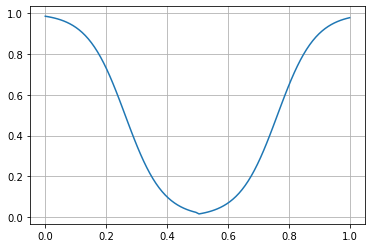

In [115]:
# Visualize su_pop
x = np.linspace(0,1,100)
y = [su_pop(x[i], 1) for i in range(100)]
plt.plot(x,y);
plt.grid()

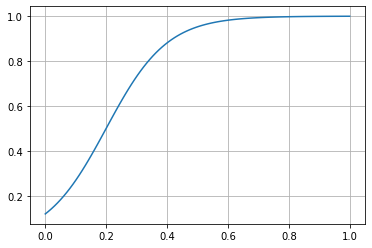

In [124]:
# Visualize su_n
x = np.linspace(0,1,100)
y = expit(10*(x)-2)
plt.plot(x,y);
plt.grid()

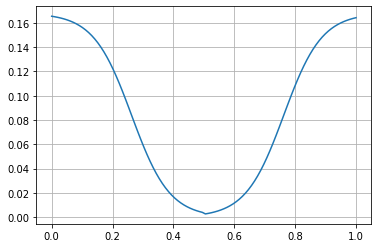

In [12]:
# Visualize total su
N = 10
n = 3
pop = np.linspace(0,1,100)
su = su_n(n, N) *  np.array([su_pop(pop[i], 1) for i in range(100)])
plt.plot(x,su);
plt.grid()